In [1]:
%matplotlib inline

In [2]:
from fenics import *
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dolfin.fem.norms as norms

import modules

## Projected gradient method
1) Initialize $q_0 \in \mathcal{Q}_{ad}$, set $k = 0$ 

2) Compute $u_k, p_k$ as solutions to (SE) and (AE) respectively

3) Define $\nu_k := - j'(q_k)$

4) Compute step length $s_k$, e.g. using the Armijo condition:     $$j(q_k + s_k \nu_k) = \min_{s > 0} j(q_k + s \nu_k)$$
    
5) Set $q_{k+1} = \mathcal{P}_{[q_a, q_b]} \{q_k + s_k \nu_k \}$


In [3]:
# --- Define mesh and function space ---

# Set time parameters
T = 4.0
num_steps = 200
dt = T/num_steps

# Define function space
nx = 64
ny = 64
mesh = UnitSquareMesh(nx,ny)
V = FunctionSpace(mesh, 'CG', 1)

# --- Specify parameters ---

element = FiniteElement("CG", triangle, 1)

q_min = 0.0
q_max = 1.0

params_old = {
    "rho": 5.0,
    "lambda_": 10.0,
    "r": 2.0,
    "alpha": 15.0,
    "a": Constant(10)
}

a0 = 1.0
a1 = 1e-01
a_tol = 1e-14
# a_exp = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a0 : a1', element=element, a0=a0, a1=a1, tol=a_tol)
# a_exp = Expression('1.4*exp(-(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)))', element=element)
a_exp = Constant(0.5)
a_const = interpolate(a_exp, V)
rho = 0.0
lambda_ = 1.4
alpha = 1e-05
r = project(Expression("1.0*sqrt(pow(x[0],2) + pow(x[1], 2))", element=element), V)
# r = Constant(0.0)

params = {
    "rho": rho,
    "lambda_": lambda_,
    "r": r,
    "alpha": alpha,
    "a": a_const
}

# rho = 5.0
# lambda_ = 10.0
# r = 2.0
# alpha = 15.0
# a = Constant(10)

In [4]:
# --- Initialization ---

# State
u_0 = Constant(0.7)  # Expression('b*exp(-a*(pow(x[0]-0.25, 2) + pow(x[1]-0.25, 2)))', degree=2, a=10, b=20)
u_n = interpolate(u_0, V)

# Control
str1 = 'b*exp(-a*pow(x[0] - (0.5 - 0.25*sin(3.14*t)), 2) - a*pow(x[1] - (0.5 - 0.25*cos(3.14*t)), 2)) + '
str2 = 'b*exp(-a*pow(x[0] - (0.5 + 0.25*sin(3.14*t)), 2) - a*pow(x[1] - (0.5 + 0.25*cos(3.14*t)), 2))'
string = str1 + str2

q = Constant((float(q_max)-float(q_min))/2)   # Expression(string, degree=2, a=50, b=10, t=0)
# q = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a1 : a0', element=element, a0=a0, a1=a1, tol=a_tol)
t = 0
Q = [interpolate(q, V)]
for i in range(num_steps):
    t += dt
    q.t = t
    Q.append(interpolate(q, V))
Q = np.asarray(Q)


# Adjoint variable
p_end = Constant(-1*params["lambda_"])
p_n = interpolate(p_end, V)

In [5]:
# --- Projected gradient loop ---


tol = 1e-02
f_tol = 1e-05
v_k = 1
v_k_norm = 1

U_initial = modules.solve_state_eq(u_0, Q, V, T, num_steps, params)


j_prev = 0
j_curr = modules.j(U_initial, Q, mesh, T, num_steps, params)
diff = abs(j_prev - j_curr)

J_list = [j_curr]

print("Initial objective function value: {} \n".format(j_curr))

it = 0
while v_k_norm > tol and diff > f_tol:
    it += 1
    
    j_prev = j_curr
    
    U = modules.solve_state_eq(u_0, Q, V, T, num_steps, params)
    P = modules.solve_adjoint_eq(p_end, U, Q, V, T, num_steps, params)
    v_k = -1*modules.dj(U, Q, P, T, num_steps, params)
    [s_k, j_curr, armijo_it] = modules.armijo(v_k, U, Q, P, V, mesh, T, num_steps, params, u_0)
    diff = abs(j_prev - j_curr)
    
    Q = Q + s_k*v_k
    Q = modules.project_to_admissible(Q, q_min, q_max, V)
    
    v_k_norm = modules.grad_norm(v_k, V, T, num_steps)
    
    modules.pg_print(j_curr, j_prev, v_k_norm, it, armijo_it, s_k)
    
    J_list.append(j_curr)


Cost Functional Data
I1: 0.8629307526451768
I2: 0.2578947368419416
I3: 5.000000000000001e-06

Initial objective function value: 0.6050410158032353 

Cost Functional Data
I1: 0.8629307526451768
I2: 0.2578947368419416
I3: 5.000000000000001e-06

Cost Functional Data
I1: -0.049210925375214584
I2: 1.4295844438706655
I3: 4.722108018905371e-06

-----------------------------------
Projected gradient iteration no. 1 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4787906471378613
Decrease in function value: 2.0838316629410967
Norm of gradient: 1.8729071664238837
-----------------------------------

Cost Functional Data
I1: -0.020655101266432465
I2: 0.7233976928731735
I3: 5.5882614818492444e-08

Cost Functional Data
I1: -0.4652241484519984
I2: 0.9794239488452194
I3: 7.837589918949071e-06

-----------------------------------
Projected gradient iteration no. 2 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4

Cost Functional Data
I1: -0.46711741658001116
I2: 1.0063307294379282
I3: 1.0934893832038094e-05

-----------------------------------
Projected gradient iteration no. 17 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4734372111241074
Decrease in function value: -0.00020654548072363
Norm of gradient: 1.4353343663884452
-----------------------------------

Cost Functional Data
I1: -0.042239858075885185
I2: 0.574997017330709
I3: 5.307583085514471e-07

Cost Functional Data
I1: -0.466780093144905
I2: 1.0064842008202248
I3: 1.0940052335660845e-05

-----------------------------------
Projected gradient iteration no. 18 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4732533539127943
Decrease in function value: -0.00018385721131308763
Norm of gradient: 1.4355946595372102
-----------------------------------

Cost Functional Data
I1: -0.0421601027493209
I2: 0.5748561355011769
I3: 5.320323840778196e-07

Cost

Cost Functional Data
I1: -0.041486325322944724
I2: 0.5741032284545342
I3: 5.404436688566089e-07

Cost Functional Data
I1: -0.4645616614617626
I2: 1.0072914771777688
I3: 1.096899886599592e-05

-----------------------------------
Projected gradient iteration no. 34 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4718421696406652
Decrease in function value: -4.559042442053851e-05
Norm of gradient: 1.4369561608290986
-----------------------------------

Cost Functional Data
I1: -0.04146065194920036
I2: 0.5740887659260845
I3: 5.405835273873211e-07

Cost Functional Data
I1: -0.46450556605238574
I2: 1.007304577378765
I3: 1.096945256068649e-05

-----------------------------------
Projected gradient iteration no. 35 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.47179917397859
Decrease in function value: -4.299566207510708e-05
Norm of gradient: 1.4369782227050327
-----------------------------------

Cost 

Cost Functional Data
I1: -0.04116732375518617
I2: 0.573868179446404
I3: 5.398126136666841e-07

Cost Functional Data
I1: -0.4638152719476645
I2: 1.0075024589945718
I3: 1.0973300489817331e-05

-----------------------------------
Projected gradient iteration no. 51 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4713067576417465
Decrease in function value: -2.3875339136614215e-05
Norm of gradient: 1.4373151924515206
-----------------------------------

Cost Functional Data
I1: -0.04115375159927531
I2: 0.573854065748854
I3: 5.397017595975607e-07

Cost Functional Data
I1: -0.46377944495423634
I2: 1.0075150853030623
I3: 1.0973480252238197e-05

-----------------------------------
Projected gradient iteration no. 52 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4712835567770464
Decrease in function value: -2.3200864700090307e-05
Norm of gradient: 1.4373367680535254
-----------------------------------

C

Cost Functional Data
I1: -0.04098724845046273
I2: 0.5737315438824865
I3: 5.381656058151796e-07

Cost Functional Data
I1: -0.46339647324057204
I2: 1.0076248103383934
I3: 1.0974471851908474e-05

-----------------------------------
Projected gradient iteration no. 68 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4710103091071134
Decrease in function value: -1.2781513355486496e-05
Norm of gradient: 1.437524095212896
-----------------------------------

Cost Functional Data
I1: -0.04097937076819075
I2: 0.5737283539072802
I3: 5.38087517192843e-07

Cost Functional Data
I1: -0.4633812368476699
I2: 1.007627672462427
I3: 1.0974459983641966e-05

-----------------------------------
Projected gradient iteration no. 69 

Armijo search ended after 0 iterations
Step length found: s_k = 1.0
New function value: -1.4709979348501132
Decrease in function value: -1.2374257000180577e-05
Norm of gradient: 1.4375289726701985
-----------------------------------

Co

In [6]:
U = modules.solve_state_eq(u_0, Q, V, T, num_steps, params)
P = modules.solve_adjoint_eq(p_end, U, Q, V, T, num_steps, params)

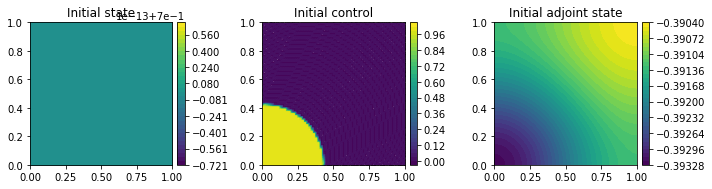

Umax = 0.7
Umin = 0.7


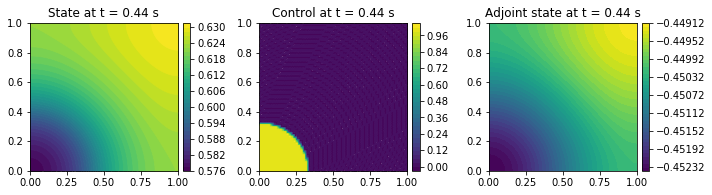

Umax = 0.6305768893022722
Umin = 0.5764572138532515


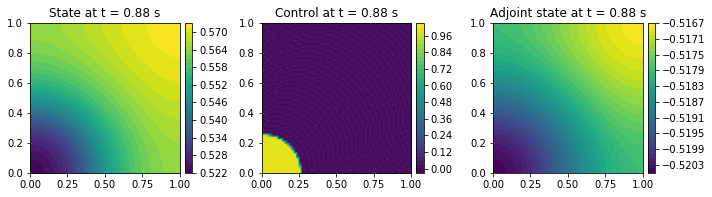

Umax = 0.5723655466451906
Umin = 0.5224090929301954


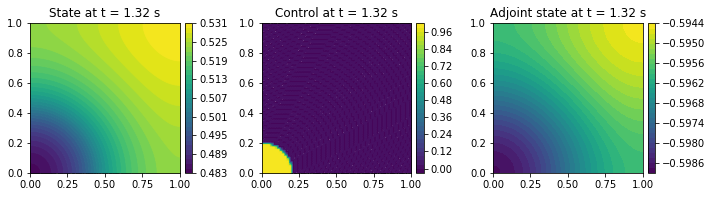

Umax = 0.530469499034069
Umin = 0.48399036790188205


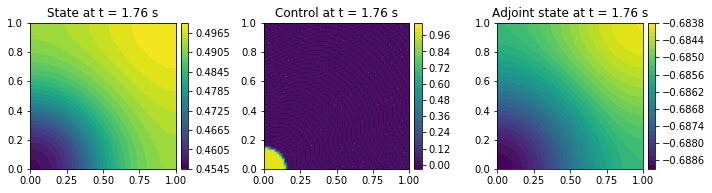

Umax = 0.49935289120833504
Umin = 0.4554800410656726


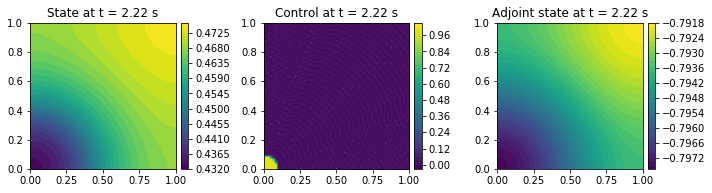

Umax = 0.47466288856723604
Umin = 0.43286891954958107


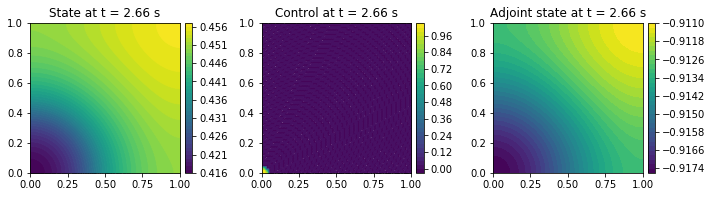

Umax = 0.45635973314216804
Umin = 0.41611303276867


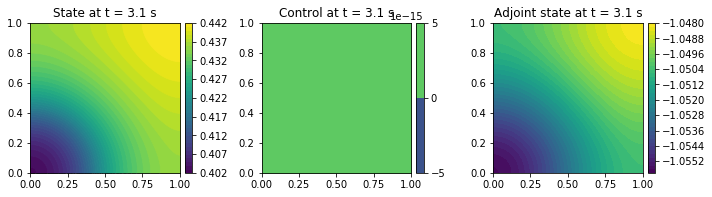

Umax = 0.4418564865728346
Umin = 0.40283954157606805


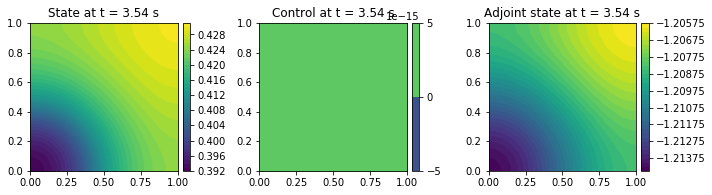

Umax = 0.4302181840406134
Umin = 0.39219044255489444


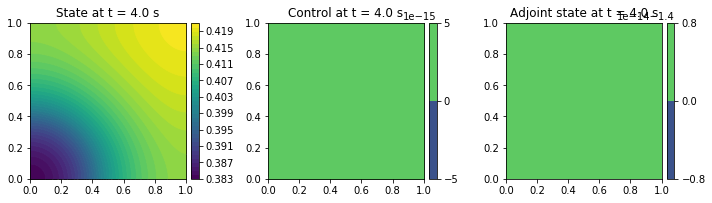

Umax = 0.42039908305601376
Umin = 0.38320756164168807


In [7]:
qmin = float(q_min)
qmax = float(q_max)
levels = np.linspace(qmin, qmax, 100)
kw_q = dict(levels=levels, vmin=qmin, vmax=qmax)
modules.plot_states_and_control(U, Q, P, T, num_steps, num_plots=10)

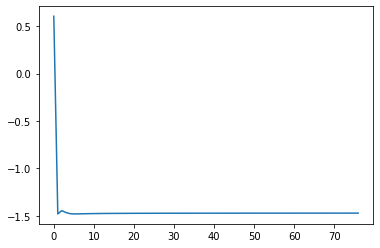

In [8]:
plt.plot(J_list)

In [38]:
indxlst = [i for i in range(len(J_list))]

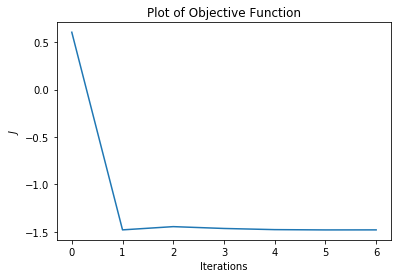

In [48]:
sub = 7


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_yscale("linear")
ax.plot(J_list[0:sub])
ax.set_xlabel("Iterations")
ax.set_ylabel(r"$J$")
ax.set_title("Plot of Objective Function")
plt.xticks(indxlst[0:sub])
plt.savefig("objective_function_high_r_ex.pdf")
plt.show()

In [84]:
def plot_states_and_control_compact(U, Q, P, T, num_steps, kw_q=None, num_plots=5):
    '''
        Function to plot states along with corresponding
        control and adjoint for each time.
    '''
    
    assert len(U) == len(Q) and len(U) == len(P),  "Lengths of arrays do not match"
    dt = T/num_steps
    indx = np.linspace(0, len(U)-1, num_plots, dtype=int)
    
    plt.figure(figsize=(9, 11))
    j = 1
    for i in indx:
        u_n = U[i]
        q_n = Q[i]
        p_n = P[i]
        t = i*dt
        
        if i == 0:
            utitle = "Initial state"
            qtitle = "Initial control"
            ptitle = "Initial adjoint state"
        else:
            utitle = "State at t = {} s".format(round(t, 2))
            qtitle = "Control at t = {} s".format(round(t, 2))
            ptitle = "Adjoint state at t = {} s".format(round(t, 2))
        
        if j < 5:
            
            # First plot is of the state
            ax1 = plt.subplot(4, 3, 1 + 3*(j-1))
            ax1.set_title(utitle)
            p = plot(u_n) #, **kw_u)
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.07)
            for c in p.collections:
                c.set_edgecolor("face")
            plt.colorbar(p, cax=cax, format='%.3f')
        
        
        
        
        
            # Second plot is of the control
            ax2 = plt.subplot(4, 3, 2 + 3*(j-1))
            ax2.set_title(qtitle)
            if kw_q != None:
                pp = plot(q_n, **kw_q)
            else:
                pp = plot(q_n)
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes("right", size="5%", pad=0.07)
            for c in pp.collections:
                c.set_edgecolor("face")
            plt.colorbar(pp, cax=cax, format="%.2f")
        
            # Third plot is of the adjoint
            ax3 = plt.subplot(4, 3, 3 + 3*(j-1))
            ax3.set_title(ptitle)
            ppp = plot(p_n) #, **kw_q)
            divider = make_axes_locatable(ax3)
            cax = divider.append_axes("right", size="5%", pad=0.07)
            for c in ppp.collections:
                c.set_edgecolor("face")
            plt.colorbar(ppp, cax=cax, format="%.3f")
        j += 1
    plt.tight_layout()
    plt.savefig("cp_high_r_ex.pdf")
    plt.show()
        

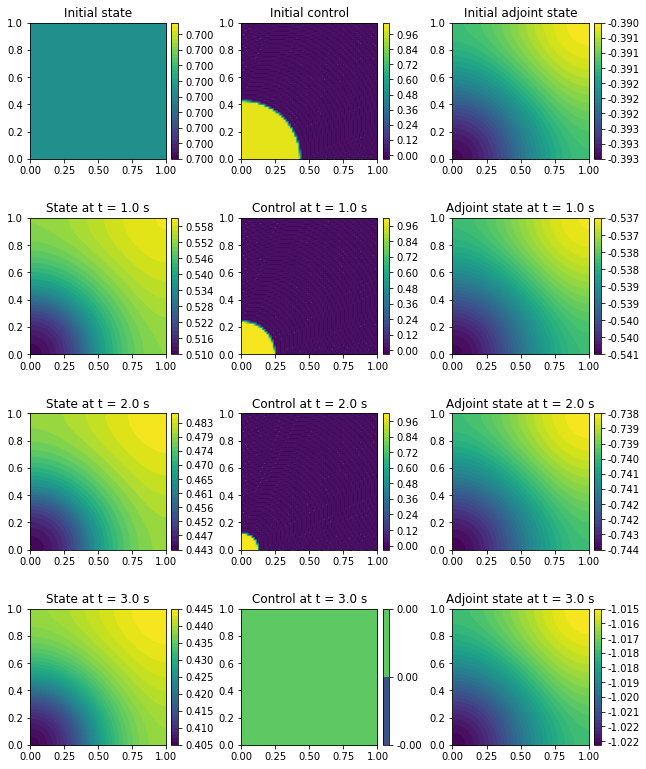

In [85]:
plot_states_and_control_compact(U, Q, P, T, num_steps)

In [ ]:
for id in [10 * i for i in range(1, 11)]:
    print(Q[id].vector().min())
    print(Q[id].vector().max())
    
    print()

In [ ]:
float(q)

In [ ]:
plut = plot(a_const)
plt.colorbar(plut)
plt.show()

In [ ]:
n_ = 80
mesh_ = UnitIntervalMesh(n_)
space = FunctionSpace(mesh_, 'P', 1)

element_ = FiniteElement('P', triangle, 1)

func = Expression('pow(x[0] - 0.5, 2) - 0.15', degree=2)
f = project(func, space)

plot(f)

In [ ]:
f.vector() < -0.10

In [ ]:
f.vector()[f.vector() < -0.10]

In [ ]:
F = [f]
F = modules.project_to_admissible(F, -0.10, 0.00, space)
plot(F[0])

In [ ]:
Q_test = []
U_test = []

q_test = Expression('exp(x[0]) + pow(t, 2)', element=element, t=0)
u_test = Expression('x[0]*x[1]*t', element=element, t=0)

t = 0
dt = T/num_steps

for i in range(num_steps + 1):
    Q_test.append(project(q_test, V))
    U_test.append(project(u_test, V))
    
    t += dt
    q_test.t = t
    u_test.t = t

In [ ]:
res = modules.j(U_test, Q_test, mesh, T, num_steps, params)

In [ ]:
res

In [ ]:
lambda_

In [ ]:
alpha

In [ ]:
q0 = 10.0
q1 = 1e-01
q_tol = 1e-14
q_exp = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a0 : a1', element=element, a0=q0, a1=q1, tol=q_tol)
Q_trial = []

for i in range(num_steps + 1):
    Q_trial.append(project(q_exp, V))
    
U_trial = modules.solve_state_eq(u_0, Q_trial, V, T, num_steps, params)
P_trial = modules.solve_adjoint_eq(p_end, U_trial, Q, V, T, num_steps, params)

In [ ]:
modules.plot_states_and_control(U_trial, Q_trial, P_trial, T, num_steps, 5)